# Activation Maximization on MNIST

Lets build the mnist model and train it for 5 epochs. It should get to about ~99% test accuracy.

In [2]:
from __future__ import print_function

import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 7s - loss: 0.2464 - acc: 0.9259 - val_loss: 0.0534 - val_acc: 0.9840
Epoch 2/5
60000/60000 [==============================] - 5s - loss: 0.0879 - acc: 0.9739 - val_loss: 0.0357 - val_acc: 0.9872
Epoch 3/5
60000/60000 [==============================] - 5s - loss: 0.0630 - acc: 0.9813 - val_loss: 0.0312 - val_acc: 0.9899
Epoch 4/5
60000/60000 [==============================] - 5s - loss: 0.0521 - acc: 0.9835 - val_loss: 0.0286 - val_acc: 0.9908
Epoch 5/5
60000/60000 [==============================] - 6s - loss: 0.0437 - acc: 0.9865 - val_loss: 0.0268 - val_acc: 0.9915
Test loss: 0.0267699461636
Test accuracy: 0.9915


## Dense Layer Visualizations

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node `i` will depend on all the other node activations. In this case, I have simplified the example by using a `Dense` node with `linear` followed by `Activation('softmax')` so there is no need to do this swapping. Keep in mind that if swapping is not done, the results might be suboptimal. Reasons for this is mentioned in the documentation.

Lets start by visualizing input that maximizes the output of node 0. Hopefully this looks like a 0.

Working on filters: [0]


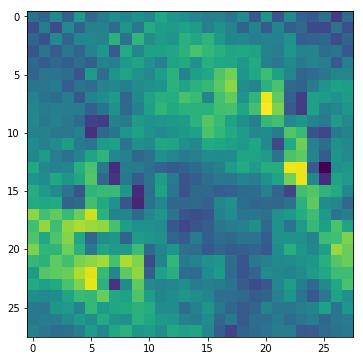

In [3]:
from vis.visualization import visualize_class_activation

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# This corresponds to the Dense linear layer.
layer_idx = -2

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_class_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])

Hmm, it sort of looks like a 0, but not as clear as we hoped for. Activation maximization is notorious because regularization parameters needs to be tuned depending on the problem. Lets enumerate all the possible reasons why this didnt work out.
    
- The input to network is preprocessed to range (0, 1). We should specify `input_range = (0., 1.)` to constraint the input to this range.
- The regularization parameter default weights might be dominating activation maximization loss weight. One way to debug this is to use `verbose=True` and examine individual loss values.
- By default Jitter(16) is used which is too much for MNIST with (28, 28) resolution. 

Lets do these step by step and see if we can improve it.

### Debugging step 1: Specifying input_range

Working on filters: [0]


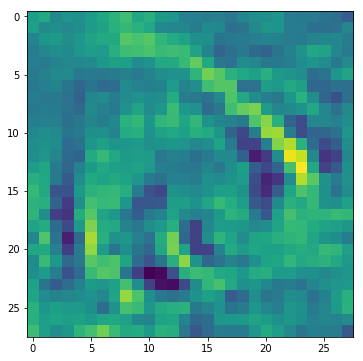

In [4]:
img = visualize_class_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.))
plt.imshow(img[..., 0])

Bit better but still seems noisy. Lets examining the losses with `verbose=True` and tuning the weights.

### Debugging step 2: Tuning regularization weights

One of the issues with activation maximization is that the input can go out of the training distribution space. Total variation and L-p norm are used to provide some hardcoded image priors for natural images. For example, Total variation ensures that images are blobber and not scattered. Unfotunately, sometimes these losses can dominate the main `ActivationMaximization` loss.

Lets see what individual losses are, with `verbose=True`

Working on filters: [0]
Iteration: 1, named_losses: [('ActivationMax Loss', 0.10967041),
 ('L-6.0 Norm Loss', 0.019846421),
 ('TV(2.0) Loss', 0.096159279)], overall loss: 0.225676104426
Iteration: 2, named_losses: [('ActivationMax Loss', 90.042969),
 ('L-6.0 Norm Loss', 0.17769031),
 ('TV(2.0) Loss', 551.70789)], overall loss: 641.928527832
Iteration: 3, named_losses: [('ActivationMax Loss', 44.526703),
 ('L-6.0 Norm Loss', 0.18987384),
 ('TV(2.0) Loss', 159.56909)], overall loss: 204.285675049
Iteration: 4, named_losses: [('ActivationMax Loss', 23.361303),
 ('L-6.0 Norm Loss', 0.13794167),
 ('TV(2.0) Loss', 112.50371)], overall loss: 136.002960205
Iteration: 5, named_losses: [('ActivationMax Loss', -15.361121),
 ('L-6.0 Norm Loss', 0.14293845),
 ('TV(2.0) Loss', 100.39212)], overall loss: 85.1739349365
Iteration: 6, named_losses: [('ActivationMax Loss', 75.284683),
 ('L-6.0 Norm Loss', 0.15359172),
 ('TV(2.0) Loss', 83.804077)], overall loss: 159.242355347
Iteration: 7, named_losses: 

Iteration: 69, named_losses: [('ActivationMax Loss', -7.86832),
 ('L-6.0 Norm Loss', 0.12430913),
 ('TV(2.0) Loss', 19.006834)], overall loss: 11.2628231049
Iteration: 70, named_losses: [('ActivationMax Loss', 6.961998),
 ('L-6.0 Norm Loss', 0.13294569),
 ('TV(2.0) Loss', 25.145958)], overall loss: 32.240901947
Iteration: 71, named_losses: [('ActivationMax Loss', 10.819974),
 ('L-6.0 Norm Loss', 0.13191622),
 ('TV(2.0) Loss', 26.172354)], overall loss: 37.1242446899
Iteration: 72, named_losses: [('ActivationMax Loss', 7.0311332),
 ('L-6.0 Norm Loss', 0.13084528),
 ('TV(2.0) Loss', 23.318134)], overall loss: 30.4801120758
Iteration: 73, named_losses: [('ActivationMax Loss', -16.792475),
 ('L-6.0 Norm Loss', 0.12665528),
 ('TV(2.0) Loss', 18.182775)], overall loss: 1.51695632935
Iteration: 74, named_losses: [('ActivationMax Loss', -64.619156),
 ('L-6.0 Norm Loss', 0.13929276),
 ('TV(2.0) Loss', 25.115562)], overall loss: -39.3643035889
Iteration: 75, named_losses: [('ActivationMax Loss',

Iteration: 129, named_losses: [('ActivationMax Loss', -7.1793995),
 ('L-6.0 Norm Loss', 0.14405647),
 ('TV(2.0) Loss', 23.022863)], overall loss: 15.9875202179
Iteration: 130, named_losses: [('ActivationMax Loss', 5.9402132),
 ('L-6.0 Norm Loss', 0.14623918),
 ('TV(2.0) Loss', 23.35969)], overall loss: 29.4461421967
Iteration: 131, named_losses: [('ActivationMax Loss', 1.0267515),
 ('L-6.0 Norm Loss', 0.14720772),
 ('TV(2.0) Loss', 22.981525)], overall loss: 24.1554851532
Iteration: 132, named_losses: [('ActivationMax Loss', 4.6450725),
 ('L-6.0 Norm Loss', 0.14419468),
 ('TV(2.0) Loss', 21.29771)], overall loss: 26.086977005
Iteration: 133, named_losses: [('ActivationMax Loss', 0.007537432),
 ('L-6.0 Norm Loss', 0.13789359),
 ('TV(2.0) Loss', 19.453876)], overall loss: 19.5993080139
Iteration: 134, named_losses: [('ActivationMax Loss', -1.0594356),
 ('L-6.0 Norm Loss', 0.13931875),
 ('TV(2.0) Loss', 19.761322)], overall loss: 18.8412055969
Iteration: 135, named_losses: [('ActivationMa

Iteration: 182, named_losses: [('ActivationMax Loss', 5.5114856),
 ('L-6.0 Norm Loss', 0.14755604),
 ('TV(2.0) Loss', 19.597157)], overall loss: 25.2561988831
Iteration: 183, named_losses: [('ActivationMax Loss', 3.7833672),
 ('L-6.0 Norm Loss', 0.14659682),
 ('TV(2.0) Loss', 19.136633)], overall loss: 23.0665969849
Iteration: 184, named_losses: [('ActivationMax Loss', -1.2726861),
 ('L-6.0 Norm Loss', 0.15061265),
 ('TV(2.0) Loss', 24.11661)], overall loss: 22.9945354462
Iteration: 185, named_losses: [('ActivationMax Loss', -23.002924),
 ('L-6.0 Norm Loss', 0.15064785),
 ('TV(2.0) Loss', 27.01885)], overall loss: 4.16657447815
Iteration: 186, named_losses: [('ActivationMax Loss', 31.019882),
 ('L-6.0 Norm Loss', 0.15819547),
 ('TV(2.0) Loss', 33.020836)], overall loss: 64.1989135742
Iteration: 187, named_losses: [('ActivationMax Loss', 0.46290451),
 ('L-6.0 Norm Loss', 0.14659232),
 ('TV(2.0) Loss', 22.239988)], overall loss: 22.8494853973
Iteration: 188, named_losses: [('ActivationMa

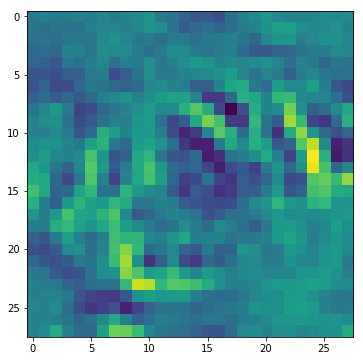

In [5]:
img = visualize_class_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), verbose=True)
plt.imshow(img[..., 0])

Notice how `ActivationMax Loss` is bouncing around and not converging? This is because weights for other losses are dominating the overall loss. The simplest way to tune these weights is to first start with `0.` weights for all regularization losses. Also, we want to disable `Jitter`, which is the default `ImageModifier`. Jitter tends to work for larger images. In smaller images, there is a risk that it destroys information by jittering the input space too much.

Working on filters: [0]
Iteration: 1, named_losses: [('ActivationMax Loss', 0.0050146244)], overall loss: 0.00501462444663
Iteration: 2, named_losses: [('ActivationMax Loss', 53.961239)], overall loss: 53.9612388611
Iteration: 3, named_losses: [('ActivationMax Loss', -207.18614)], overall loss: -207.186141968
Iteration: 4, named_losses: [('ActivationMax Loss', -445.92752)], overall loss: -445.927520752
Iteration: 5, named_losses: [('ActivationMax Loss', -665.17352)], overall loss: -665.173522949
Iteration: 6, named_losses: [('ActivationMax Loss', -871.44458)], overall loss: -871.444580078
Iteration: 7, named_losses: [('ActivationMax Loss', -1055.3274)], overall loss: -1055.32739258
Iteration: 8, named_losses: [('ActivationMax Loss', -1238.3857)], overall loss: -1238.38574219
Iteration: 9, named_losses: [('ActivationMax Loss', -1408.6544)], overall loss: -1408.65441895
Iteration: 10, named_losses: [('ActivationMax Loss', -1568.5303)], overall loss: -1568.53027344
Iteration: 11, named_lo

Iteration: 91, named_losses: [('ActivationMax Loss', -10307.011)], overall loss: -10307.0107422
Iteration: 92, named_losses: [('ActivationMax Loss', -10408.33)], overall loss: -10408.3300781
Iteration: 93, named_losses: [('ActivationMax Loss', -10509.605)], overall loss: -10509.6054688
Iteration: 94, named_losses: [('ActivationMax Loss', -10611.914)], overall loss: -10611.9140625
Iteration: 95, named_losses: [('ActivationMax Loss', -10715.309)], overall loss: -10715.3085938
Iteration: 96, named_losses: [('ActivationMax Loss', -10816.861)], overall loss: -10816.8613281
Iteration: 97, named_losses: [('ActivationMax Loss', -10919.391)], overall loss: -10919.390625
Iteration: 98, named_losses: [('ActivationMax Loss', -11018.724)], overall loss: -11018.7236328
Iteration: 99, named_losses: [('ActivationMax Loss', -11121.286)], overall loss: -11121.2861328
Iteration: 100, named_losses: [('ActivationMax Loss', -11222.648)], overall loss: -11222.6484375
Iteration: 101, named_losses: [('Activati

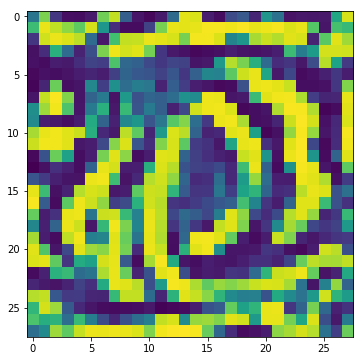

In [6]:
img = visualize_class_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                                 tv_weight=0., lp_norm_weight=0., image_modifiers=None, verbose=True)
plt.imshow(img[..., 0])

Seems much better. Lets try to introduce total variation and see what happens.

Working on filters: [0]
Working on filters: [0]
Working on filters: [0]
Working on filters: [0]
Working on filters: [0]


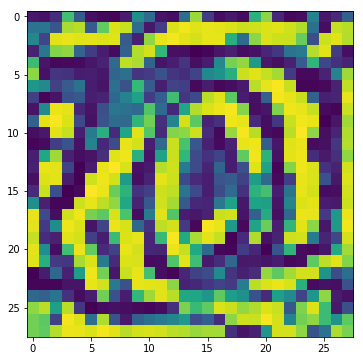

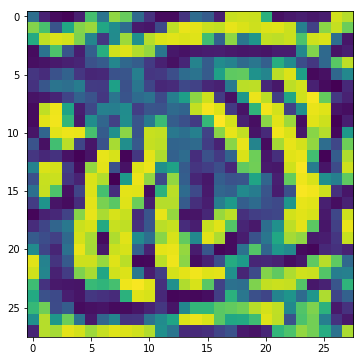

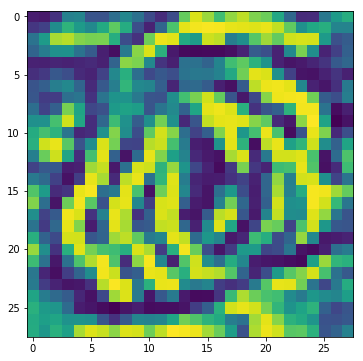

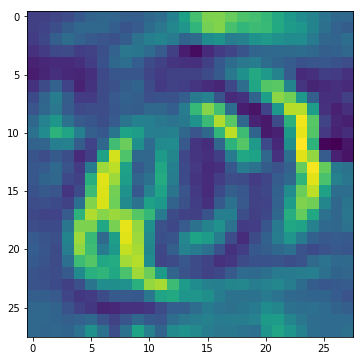

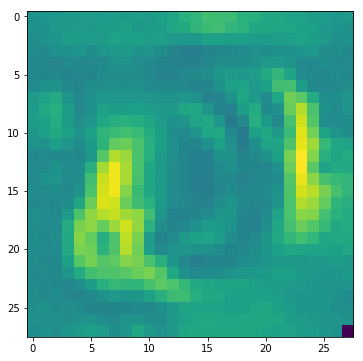

In [7]:
for tv_weight in [1e-3, 1e-2, 1e-1, 1, 10]:
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_class_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                                     tv_weight=tv_weight, lp_norm_weight=0., image_modifiers=None)
    plt.figure()
    plt.imshow(img[..., 0])

We can see how total variation loss is enforcing blobbiness. These look much better and closer to 0. Looks like TV weight of [1, 10] are most promising.

Once we know this, we should be able to use these parameters on a different output node for sanity check.

Working on filters: [5]
Working on filters: [5]


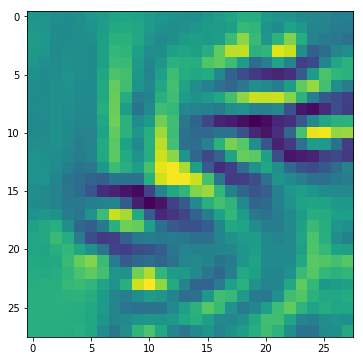

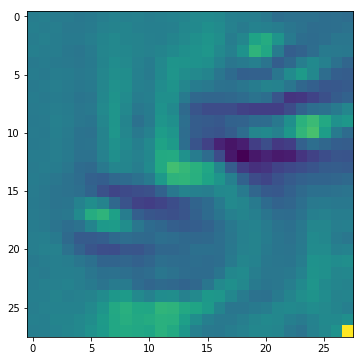

In [9]:
for tv_weight in [1, 10]:
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_class_activation(model, layer_idx, filter_indices=5, input_range=(0., 1.), 
                                     tv_weight=tv_weight, lp_norm_weight=0., image_modifiers=None)
    plt.figure()
    plt.imshow(img[..., 0])

Close enough! Obviously things can get better if you expeirment with Jitter and lp-norm weights and so on. Basically, a regularizer is needed to enforce image naturalness prior which limits the input image search space.

I hope GANs should come to your mind at this point. We could easily take a GAN trained on mnist and use discriminator loss as a regularizer. This is a work on progress. Feel free to submit a PR though :)